https://www.kaggle.com/c/nlp-getting-started

First Attempt
- Used a Linear Model with Ridge Regression
    - Tokenized the training set using Count Vectorizer
    - Used Ridge Regression Classifier to learn on the training set
    - Used cross validation to assess accuracy on various parts of training set
        - Averaged 60% accuracy (10% better than random)
    - Tokenized the testing set with training vectorizer 
        - Used learned ridge regression classifier to predict on test set 
            - How Ridge Regression differs from Linear
                - https://www.youtube.com/watch?v=OEU22e20tWw
                - Uses an alpha to generalize the line of best fit so that it doesn't overfit to the training data 
                
Second Attempt

- Used a Linear Model with Ridge Regression
    - Tokenized the training set using tfidf vecotorizer
        - https://www.quora.com/How-does-TfidfVectorizer-work-in-laymans-terms
        - https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XnlXaVNKhQI
    - Used Ridge Regression Classifier to learn on the training set
    - Used cross validation to assess accuracy on various parts of training set
        - Averaged 64% accuracy (14% better than random)
    - Tokenized the testing set with training vectorizer 
        - Used learned ridge regression classifier to predict on test set 
            - How Ridge Regression differs from Linear
                - https://www.youtube.com/watch?v=OEU22e20tWw
                - Uses an alpha to generalize the line of best fit so that it doesn't overfit to the training data


You can actually specify a custom stop word list, enforce minimum word count, etc. See this article on how to use CountVectorizer
- https://medium.com/hackernoon/presidential-debate-sentiment-analysis-with-lstm-onevsrest-linearsvc-nlp-step-by-step-guide-b9683e2c8ed9

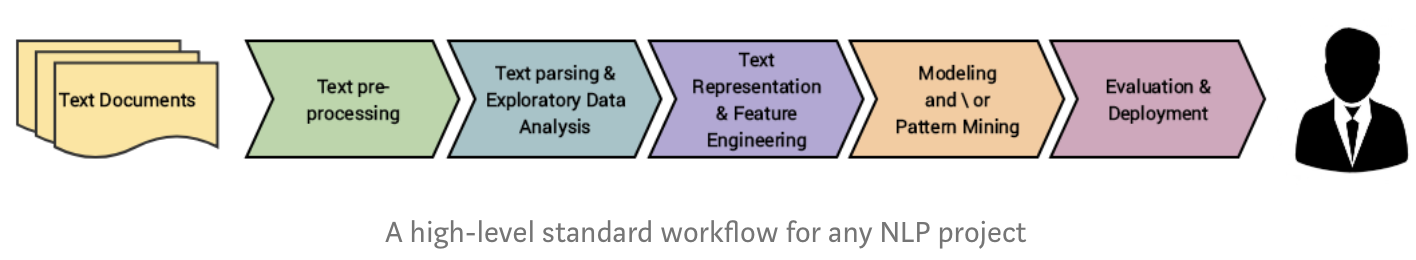

- Removed Special Characters and Numbers
- Stemming using Porter stemmer to standardize words to their word stem
- Lemmatized using mltk lemmatizer to standardoze words to their root word (always present in dictionary)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize.toktok import ToktokTokenizer
import re


# Expanding Contractions?

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayusharora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayusharora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayusharora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ayusharora/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
NA = pd.DataFrame(columns = {"train","test"})

In [6]:
NA['train'] = train.isnull().sum()
NA['test'] = test.isnull().sum()
NA

# NAs in keyword and location

,test,train
id,0.0,0
keyword,26.0,61
location,1105.0,2533
text,0.0,0
target,NaN,0


In [7]:
# Real vs Fake breakdown

train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

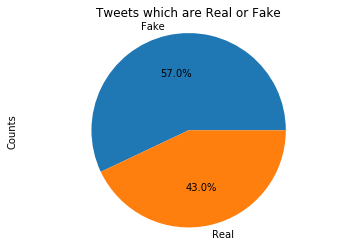

In [8]:
# Pie chart of Real vs Fake breakdown
real = len(train[train['target'] == 1])
fake = len(train[train['target'] == 0])

pie_chart = pd.DataFrame({
                          'Class': ['Real','Fake'],
                          'Counts': [real,fake]
                         }
                        )
pie_chart.Counts.groupby(pie_chart.Class).sum().plot(kind = 'pie',autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Tweets which are Real or Fake')
plt.show()

In [9]:
stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')
def remove_stop_words(text):
    word_tokens = word_tokenize(text) 
    filtered = [token for token in word_tokens if token.lower() not in stop_words]
    filtered = ' '.join(filtered)
    return filtered

def remove_special_characters(text,remove_digits = False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern,'',text)
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word)for word in text.split()])
    return text
def lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word)for word in text.split()])
    return text


In [10]:
for i, row in train.iterrows():
    new_text = remove_stop_words(train.at[i,'text'])
    new_text = remove_special_characters(train.at[i,'text'], remove_digits = True)
    new_text = lemmatize(new_text)
    #new_text = simple_stemmer(new_text)
    train.at[i,'text'] = new_text

In [11]:
type(new_text)

str

In [12]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All resident asked to shelter in place are bei...,1
3,6,NaN,NaN,people receive wildfire evacuation order in Ca...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska a sm...,1


In [13]:
# Count words in each tweet
#count_vectorizer = feature_extraction.text.CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer(use_idf=True)

In [14]:
#example_train_vector = count_vectorizer.fit_transform(train['text'][0:5])
example_train_vectors = tf_idf_vectorizer.fit_transform(train['text'][0:5])

In [15]:
example_train_vectors

<5x50 sparse matrix of type '<class 'numpy.float64'>'
	with 57 stored elements in Compressed Sparse Row format>

In [16]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All resident asked to shelter in place are bei...,1
3,6,NaN,NaN,people receive wildfire evacuation order in Ca...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska a sm...,1


In [17]:
first_vector = example_train_vectors[0]

In [18]:
df = pd.DataFrame(first_vector.T.todense(),index = tf_idf_vectorizer.get_feature_names(),columns=['tfidf'])
df.sort_values(by=['tfidf'],ascending = False)

,tfidf
deeds,0.302161
the,0.302161
forgive,0.302161
may,0.302161
earthquake,0.302161
of,0.302161
reason,0.302161
our,0.302161
allah,0.302161
this,0.243782


In [19]:
# 54 unique tokens/words in first 5 tweets
example_train_vectors[0].todense().shape

(1, 50)

In [20]:
#train_vectors = count_vectorizer.fit_transform(train['text'])
train_vectors = tf_idf_vectorizer.fit_transform(train['text'])

In [21]:
# what are the tokens
#print(count_vectorizer.get_feature_names())
print(tf_idf_vectorizer.get_feature_names())

['__', '__ohhmyjoshh', '__scrambledeggs', '__srajapakse__', '_animaladvocate', '_ashj', '_asianshawtyy', '_bookofdaniel', '_charleyisqueen', '_chelsdelong', '_dangdaddy', '_dangerousbeans', '_dc', '_dmerida', '_doofus_', '_edvinnn', '_explicitpretty', '_freemarketeer', '_gaabyx', '_itsdanie_', '_itsmegss_', '_itzsteven', '_jeesss_', '_keits', '_minimehh', '_ohhsehuns', '_oliviaann_', '_one', '_onlyftf', '_pokemoncards_', '_reddevillife_', '_rosewell', '_stiiilo', '_wildfire__', 'a_', 'a__cee', 'aa', 'aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aace_org', 'aal', 'aampb', 'aampw', 'aan', 'aannnnd', 'aar', 'aaronthefm', 'aashiqui', 'ab', 'aba', 'abandon', 'abandoned', 'abandonedpics', 'abandoning', 'abbandoned', 'abbott', 'abbruchsimulator', 'abbswinston', 'abbyairshow', 'abc', 'abcchicago', 'abceyewitness', 'abcnews', 'abcnorio', 'abcs', 'abe', 'aberdeen', 'aberdeenfanpage', 'aberdeenfc', 'aberystwythshrewsbury', 'abes', 'abha', 'abia', 'ability', 'abject', 'ablaze', 'able', 'ableg

In [22]:
train[train['target'] == 1]['text'].values[4]

'Just got sent this photo from Ruby Alaska a smoke from wildfire pours into a school'

In [23]:
# to make sure train and test use same tokens, use transform on test
#test_vectors = count_vectorizer.transform(test['text'])
test_vectors = tf_idf_vectorizer.transform(test['text'])

In [24]:
# Assuming a linear connection between tweet words and whether they're about a real disaster or not

# Ridge Regression to overcome overfitting by generalizing and increasing bias by introducng an alpha to adjust the line that trains on data 
# Increasing alpha makes model less sensitive to variation
clf = linear_model.RidgeClassifier()


In [25]:
# Use cross validation to see how well it trains on various portions of training data

scores = model_selection.cross_val_score(clf,train_vectors, train['target'],cv = 3,scoring ='f1')
scores
 
# Ridge Regression w/ countvectorizer: averages around 58-64% accuracy 
# Ridge Regression w/ tfidfvectorizer: averages around 61-68% accuracy
# Ridge Regression w/ tfidfvectorizer and removed stopwords: 58%-70% accuracy (increased range)

array([0.65030005, 0.59937238, 0.67174797])

In [26]:
clf.fit(train_vectors, train['target'])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [27]:
sample_submission = pd.read_csv('sample_submission.csv')

In [28]:
sample_submission['target'] = clf.predict(test_vectors)

In [29]:
sample_submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [30]:
sample_submission.to_csv('submisssion.csv',index = False)

In [31]:
tester = pd.read_csv('tester.csv')

In [32]:
#tester_vectors = count_vectorizer.transform(tester['text'])
tester_vectors = tf_idf_vectorizer.transform(tester['text'])

In [33]:
tester['target'] = clf.predict(tester_vectors)

In [34]:
tester

,id,keyword,location,text,target
0,0.0,NaN,NaN,rock!,0
1,1.0,NaN,NaN,paper!,0
2,2.0,NaN,NaN,scissors!,0
3,3.0,NaN,NaN,wildfire,1
4,NaN,NaN,NaN,i drew a wildfire on paper,1
5,NaN,NaN,NaN,this wildfire was made by paper,1
